In [ ]:
#Import the libraries we need
import pandas as pd
import numpy as np

In [ ]:
#Read in the market data
nzd_jpy = pd.read_csv('Market Data NZDJPY.csv')

In [ ]:
#Format the data
nzd_jpy = nzd_jpy[::-1]
nzd_jpy.reset_index(inplace=True, drop=True)

In [ ]:
#Labelling the data
nzd_jpy['Target'] = nzd_jpy['Close'].shift(-20)
nzd_jpy.dropna(inplace=True)

In [ ]:
#Add binary target for plotting
nzd_jpy['Binary Target'] = np.nan
nzd_jpy.loc[nzd_jpy['Close'] > nzd_jpy['Target'],'Binary Target'] = 1
nzd_jpy.loc[nzd_jpy['Close'] <= nzd_jpy['Target'],'Binary Target'] = 0

In [ ]:
#Current state of our dataframe
nzd_jpy

Time    Open    High     Low   Close  Target  \
0     2024.07.11 09:19:00  98.349  98.351  98.341  98.350  98.349   
1     2024.07.11 09:20:00  98.350  98.351  98.335  98.335  98.356   
2     2024.07.11 09:21:00  98.335  98.343  98.334  98.336  98.358   
3     2024.07.11 09:22:00  98.335  98.339  98.327  98.339  98.356   
4     2024.07.11 09:23:00  98.339  98.340  98.322  98.325  98.359   
...                   ...     ...     ...     ...     ...     ...   
9976  2024.07.22 09:30:00  93.997  94.016  93.985  94.005  94.026   
9977  2024.07.22 09:31:00  94.006  94.017  93.998  94.006  94.025   
9978  2024.07.22 09:32:00  94.006  94.015  94.003  94.003  94.024   
9979  2024.07.22 09:33:00  94.003  94.016  94.003  94.010  94.031   
9980  2024.07.22 09:34:00  94.010  94.017  94.005  94.016  94.017   

      Binary Target  
0               1.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
9976            0.0  
9977            0.0  
9978            0.0  
9979            0.0  
9980            0.0  

[9981 rows x 7 columns]

In [ ]:
#Store the predictors and target
X = ['Close']
y = ['Target']

<Axes: xlabel='Open', ylabel='Close'>

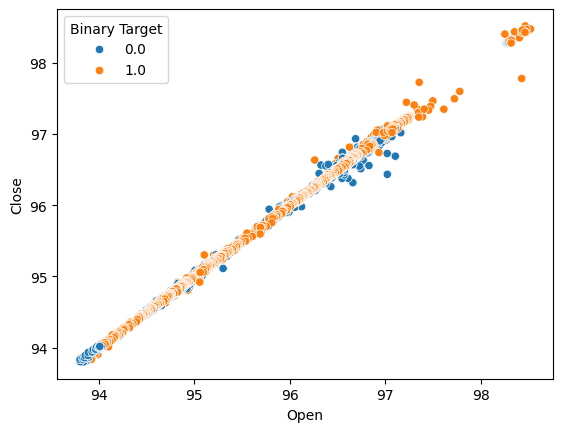

In [ ]:
#Lets perform scatter plots
sns.scatterplot(data=nzd_jpy,x=nzd_jpy['Open'], y=nzd_jpy['Close'],hue='Binary Target')

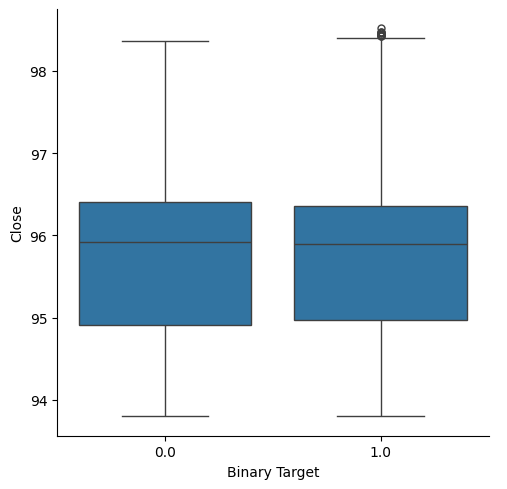

In [ ]:
#Let's create categorical box plots
sns.catplot(data=nzd_jpy,x='Binary Target',y='Close',kind='box')

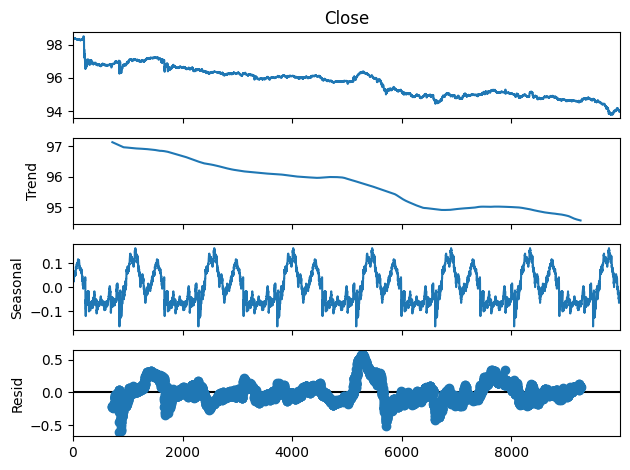

In [ ]:
#Time series decomposition
import statsmodels.api as sm
nzd_jpy_decomposition = sm.tsa.seasonal_decompose(nzd_jpy['Close'],period=1440,model='additive')
fig = nzd_jpy_decomposition.plot()

Text(0.5, 0, 'NZDJPY Close')

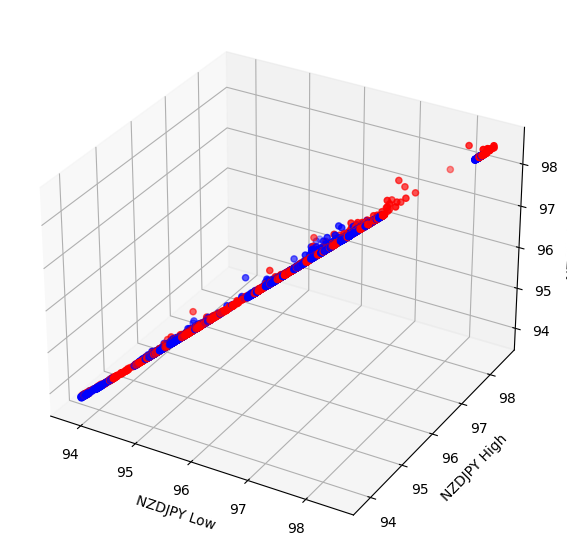

In [ ]:
#Let's also perform 3D plots
#Visualizing our data in 3D

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111,projection='3d')
colors = ['blue' if movement == 0 else 'red' for movement in nzd_jpy.loc[:,"Binary Target"]]
ax.scatter(nzd_jpy.loc[:,"Low"],nzd_jpy.loc[:,"High"],nzd_jpy.loc[:,"Close"],c=colors)

ax.set_xlabel('NZDJPY Low')
ax.set_ylabel('NZDJPY High')
ax.set_zlabel('NZDJPY Close')

In [ ]:
#Let's prepare the data for modelling
from sklearn.preprocessing import RobustScaler

In [ ]:
#Scale the data
X = pd.DataFrame(RobustScaler().fit_transform(nzd_jpy.loc[:,['Close']]),columns=['Close'])
residuals_X = pd.DataFrame(RobustScaler().fit_transform(nzd_jpy.loc[:,['Open','High','Low']]),columns=['Open','High','Low'])
y = nzd_jpy.loc[:,'Target']

In [ ]:
#Cross validating the models
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.linear_model import Lasso,LinearRegression,Ridge,ElasticNet,SGDRegressor,HuberRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor,BaggingRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

In [ ]:
#Create train-test splits
train_X,test_X,train_y,test_y = train_test_split(nzd_jpy.loc[:,['Close']],y,test_size=0.5,shuffle=False)
residuals_train_X,residuals_test_X,residuals_train_y,residuals_test_y = train_test_split(nzd_jpy.loc[:,['Open','High','Low']],y,test_size=0.5,shuffle=False)

In [ ]:
#Store the models
models = [
    Lasso(),
    LinearRegression(),
    Ridge(),
    ElasticNet(),
    SGDRegressor(),
    HuberRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    ExtraTreesRegressor(),
    BaggingRegressor(),
    LinearSVR(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    MLPRegressor(),
]

#Store the names of the models
model_names = [
    'Lasso',
    'Linear Regression',
    'Ridge',
    'Elastic Net',
    'SGD Regressor',
    'Huber Regressor',
    'Random Forest Regressor',
    'Gradient Boosting Regressor',
    'Ada Boost Regressor',
    'Extra Trees Regressor',
    'Bagging Regressor',
    'Linear SVR',
    'K Neighbors Regressor',
    'Decision Tree Regressor',
    'MLP Regressor',
]

#Create a dataframe to store our cv error
cv_error = pd.DataFrame(columns=model_names,index=np.arange(0,5))

In [ ]:
#Cross validate each model
for model in models:
  cv_score = cross_val_score(model,X,y,cv=5,n_jobs=-1,scoring='neg_mean_squared_error')
  for i in np.arange(0,5):
    index = models.index(model)
    cv_error.iloc[i,index] = cv_score[i]

In [ ]:
cv_error

Lasso Linear Regression     Ridge Elastic Net SGD Regressor  \
0 -2.796138         -0.025146 -0.025023   -2.796138     -0.024756   
1 -0.399354         -0.002398 -0.002405   -0.252566     -0.002422   
2 -0.112924         -0.004656 -0.004628   -0.066933     -0.004612   
3 -0.969806         -0.004747 -0.004736   -0.743396     -0.004771   
4 -1.964471         -0.005131 -0.005154   -1.964471      -0.00499   

  Huber Regressor Random Forest Regressor Gradient Boosting Regressor  \
0       -0.025572                -0.38379                   -0.376826   
1       -0.002346               -0.005345                    -0.00449   
2       -0.004613               -0.017665                   -0.013233   
3       -0.004789                -0.00684                   -0.005454   
4       -0.004746               -0.061634                   -0.053681   

  Ada Boost Regressor Extra Trees Regressor Bagging Regressor Linear SVR  \
0            -0.48874              -0.38727         -0.385572  -0.025295   
1             -0.0214             -0.004955         -0.006217  -0.002357   
2           -0.061245             -0.007936         -0.017067  -0.004603   
3           -0.024552             -0.007172         -0.006807  -0.004844   
4           -0.115191             -0.065645         -0.059035  -0.004712   

  K Neighbors Regressor Decision Tree Regressor MLP Regressor  
0             -0.379035               -0.388334    -109.74771  
1             -0.005304               -0.008801     -0.014419  
2             -0.015305               -0.019244      -0.00616  
3             -0.006779               -0.012266      -0.01253  
4             -0.056748               -0.063217     -8.932602

<Axes: >

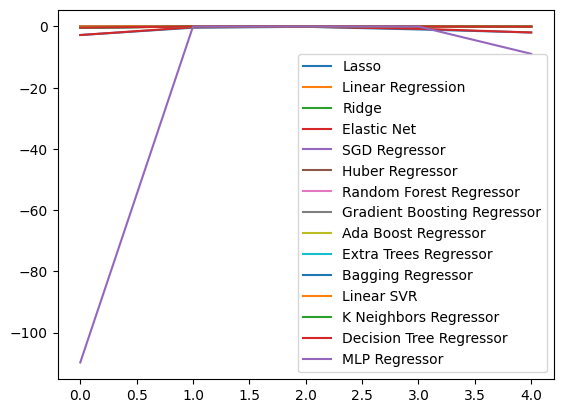

In [ ]:
cv_error.plot()

<Axes: >

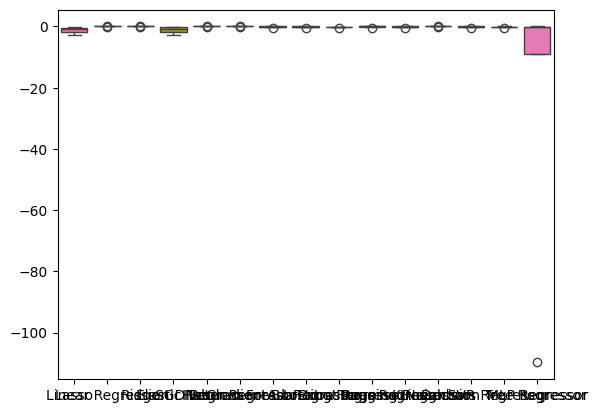

In [ ]:
sns.boxplot(cv_error)

In [ ]:
#Our mean validation error
cv_error.mean()

Lasso                          -1.248539
Linear Regression              -0.008416
Ridge                          -0.008389
Elastic Net                    -1.164701
SGD Regressor                   -0.00831
Huber Regressor                -0.008413
Random Forest Regressor        -0.095055
Gradient Boosting Regressor    -0.090737
Ada Boost Regressor            -0.142225
Extra Trees Regressor          -0.094596
Bagging Regressor               -0.09494
Linear SVR                     -0.008362
K Neighbors Regressor          -0.092634
Decision Tree Regressor        -0.098372
MLP Regressor                 -23.742684
dtype: object

In [ ]:
#Feature importance
from sklearn.feature_selection import mutual_info_regression,RFE

In [ ]:
mi_score = pd.DataFrame(mutual_info_regression(X,y),columns=['MI Score'],index=X.columns)

<Axes: >

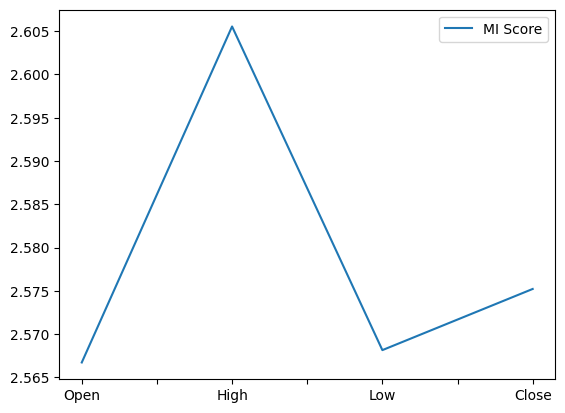

In [ ]:
mi_score.plot()

In [ ]:
#Select the best features
rfe = RFE(model, n_features_to_select=5, step=1)
rfe = rfe.fit(X, y)
rfe.ranking_

In [ ]:
#Parameter tuning
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
#Initialize the model
model = SGDRegressor()

In [ ]:
#Define the tuner
tuner = RandomizedSearchCV(
        model,
        {
        "loss" : ['squared_error', 'huber', 'epsilon_insensitive','squared_epsilon_insensitive'],
        "penalty":['l2','l1', 'elasticnet', None],
        "alpha":[0.1,0.01,0.001,0.0001,0.00001,0.00001,0.0000001,10,100,1000,10000,100000],
        "tol":[0.1,0.01,0.001,0.0001,0.00001,0.000001,0.0000001],
        "fit_intercept": [True,False],
        "early_stopping": [True,False],
        "learning_rate":['constant','optimal','adaptive','invscaling'],
        "shuffle": [True,False]
        },
        n_iter=100,
        cv=5,
        n_jobs=-1,
        scoring="neg_mean_squared_error"
)

In [ ]:
#Fit the tuner
tuner.fit(train_X,train_y)

RandomizedSearchCV(cv=5, estimator=SGDRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'alpha': [0.1, 0.01, 0.001, 0.0001,
                                                  1e-05, 1e-05, 1e-07, 10, 100,
                                                  1000, 10000, 100000],
                                        'early_stopping': [True, False],
                                        'fit_intercept': [True, False],
                                        'learning_rate': ['constant', 'optimal',
                                                          'adaptive',
                                                          'invscaling'],
                                        'loss': ['squared_error', 'huber',
                                                 'epsilon_insensitive',
                                                 'squared_epsilon_insensitive'],
                                        'penalty': ['l2', 'l1', 'elasticnet',
                                                    None],
                                        'shuffle': [True, False],
                                        'tol': [0.1, 0.01, 0.001, 0.0001, 1e-05,
                                                1e-06, 1e-07]},
                   scoring='neg_mean_squared_error')

In [ ]:
#Our best parameters
tuner.best_params_

{'tol': 0.001,
 'shuffle': False,
 'penalty': 'elasticnet',
 'loss': 'huber',
 'learning_rate': 'adaptive',
 'fit_intercept': True,
 'early_stopping': True,
 'alpha': 1e-05}

In [ ]:
#Model validation
model = SGDRegressor(
    tol             = tuner.best_params_['tol'],
    shuffle         = tuner.best_params_['shuffle'],
    penalty         = tuner.best_params_['penalty'],
    loss            = tuner.best_params_['loss'],
    learning_rate   = tuner.best_params_['learning_rate'],
    alpha           = tuner.best_params_['alpha'],
    fit_intercept   = tuner.best_params_['fit_intercept'],
    early_stopping  = tuner.best_params_['early_stopping']
)
model.fit(train_X,train_y)
residuals = test_y - model.predict(test_X)

AttributeError: 'RandomSearch' object has no attribute 'best_params_'

<Axes: >

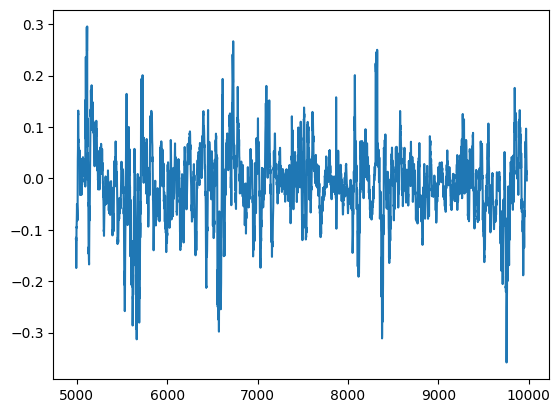

In [ ]:
#Plot the residuals
residuals.plot()

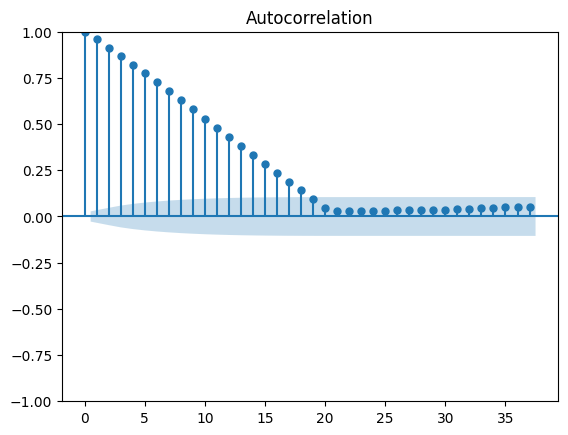

In [ ]:
#The residuals appear to have autocorrelation
from statsmodels.graphics.tsaplots import plot_acf
fig = plot_acf(residuals)

In [ ]:
#Prepare the residuals for our second model
model = SGDRegressor(tol= 0.001,
 shuffle=False,
 penalty= 'elasticnet',
 loss= 'huber',
 learning_rate='adaptive',
 fit_intercept= True,
 early_stopping= True,
 alpha= 1e-05)

#Store the model residuals
model.fit(train_X,train_y)
residuals_train_y = train_y - model.predict(train_X)
residuals_test_y = test_y - model.predict(test_X)

In [ ]:
#Cross validate each model
for model in models:
  cv_score = cross_val_score(model,residuals_train_X,residuals_train_y,cv=5,n_jobs=-1,scoring='neg_mean_squared_error')
  for i in np.arange(0,5):
    index = models.index(model)
    cv_error.iloc[i,index] = cv_score[i]

In [ ]:
#Cross validaton error levels
cv_error

Lasso Linear Regression     Ridge Elastic Net  \
0 -0.040032         -0.043527 -0.040959   -0.040032   
1  -0.00974         -0.010958 -0.010732    -0.00974   
2 -0.002082         -0.002012 -0.002004   -0.002082   
3 -0.002571         -0.002748 -0.002693   -0.002571   
4 -0.001369         -0.002179 -0.002131   -0.001369   

                   SGD Regressor Huber Regressor Random Forest Regressor  \
0 -192948047303424420433887232.0       -0.045428               -0.057302   
1 -213678947504784247363731456.0       -0.009641               -0.043703   
2 -192374253869870273093697536.0       -0.002124               -0.010268   
3 -127145506868814302104518656.0       -0.002552               -0.003641   
4  -21855463196426302830673920.0       -0.001502               -0.005615   

  Gradient Boosting Regressor Ada Boost Regressor Extra Trees Regressor  \
0                    -0.05008           -0.049339             -0.057158   
1                   -0.038536           -0.034013             -0.039192   
2                   -0.006302           -0.003276             -0.010723   
3                   -0.002772           -0.002739             -0.003596   
4                   -0.003562           -0.001798             -0.006724   

  Bagging Regressor Linear SVR K Neighbors Regressor Decision Tree Regressor  \
0         -0.056129  -0.042085             -0.055784                -0.07092   
1         -0.049872  -0.025623              -0.04141               -0.099194   
2          -0.01125  -0.003165             -0.007445               -0.013764   
3         -0.003799  -0.004416              -0.00348                -0.00485   
4          -0.00533  -0.015912             -0.003542                -0.00558   

  MLP Regressor  
0     -0.040093  
1     -0.009754  
2     -0.002085  
3     -0.002603  
4     -0.001395

In [ ]:
#Store the model's performance
cv_error.mean().sort_values(ascending=False)

Lasso                                              -0.011159
Elastic Net                                        -0.011159
MLP Regressor                                      -0.011186
Ridge                                              -0.011704
Huber Regressor                                    -0.012249
Linear Regression                                  -0.012285
Ada Boost Regressor                                -0.018233
Linear SVR                                          -0.01824
Gradient Boosting Regressor                         -0.02025
K Neighbors Regressor                              -0.022332
Extra Trees Regressor                              -0.023478
Random Forest Regressor                            -0.024106
Bagging Regressor                                  -0.025276
Decision Tree Regressor                            -0.038862
SGD Regressor                 -149600443748663896280399872.0
dtype: object

<Axes: >

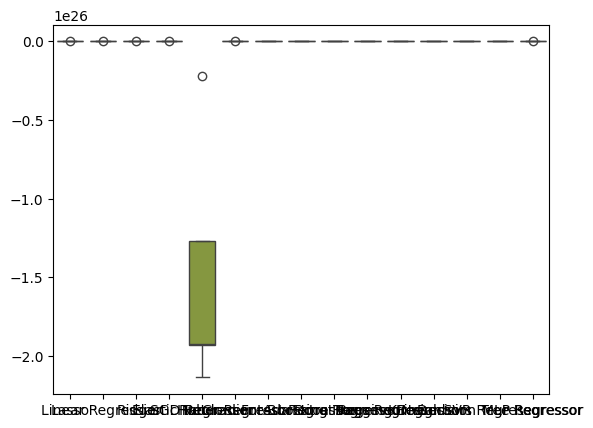

In [ ]:
sns.boxplot(cv_error)

<Axes: >

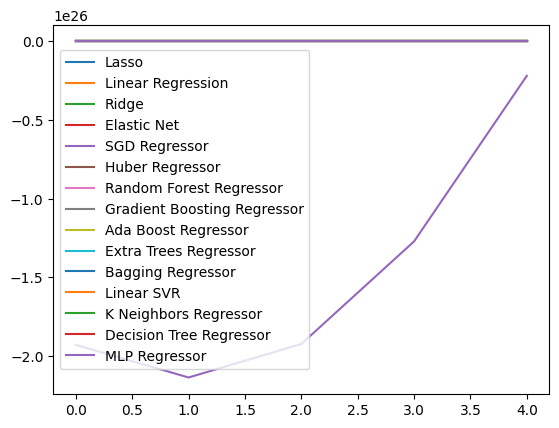

In [ ]:
cv_error.plot()

In [ ]:
#Let's tune the model
#Reinitialize the model

model = MLPRegressor()

#Define the tuner

tuner = RandomizedSearchCV(
        model,
        {
                "activation":["relu","tanh","logistic","identity"],
                "solver":["adam","sgd","lbfgs"],
                "alpha":[0.1,0.01,0.001,0.00001,0.000001],
                "learning_rate": ["constant","invscaling","adaptive"],
                "learning_rate_init":[0.1,0.01,0.001,0.0001,0.000001,0.0000001],
                "power_t":[0.1,0.5,0.9,0.01,0.001,0.0001],
                "shuffle":[True,False],
                "tol":[0.1,0.01,0.001,0.0001,0.00001],
                "hidden_layer_sizes":[(10,20),(100,200),(30,200,40),(5,20,6)],
                "max_iter":[10,50,100,200,300],
                "early_stopping":[True,False]
        },
        n_iter=100,
        cv=5,
        n_jobs=-1,
        scoring="neg_mean_squared_error"
)

In [ ]:
#Fit the tuner
tuner.fit(residuals_train_X,residuals_train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 753, in fit
    return self._fit(X, y, incremental=False)
  File "/usr/lo

RandomizedSearchCV(cv=5, estimator=MLPRegressor(), n_iter=100, n_jobs=-1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'logistic', 'identity'],
                                        'alpha': [0.1, 0.01, 0.001, 1e-05,
                                                  1e-06],
                                        'early_stopping': [True, False],
                                        'hidden_layer_sizes': [(10, 20),
                                                               (100, 200),
                                                               (30, 200, 40),
                                                               (5, 20, 6)],
                                        'learning_rate': ['constant',
                                                          'invscaling',
                                                          'adaptive'],
                                        'learning_rate_init': [0.1, 0.01, 0.001,
                                                               0.0001, 1e-06,
                                                               1e-07],
                                        'max_iter': [10, 50, 100, 200, 300],
                                        'power_t': [0.1, 0.5, 0.9, 0.01, 0.001,
                                                    0.0001],
                                        'shuffle': [True, False],
                                        'solver': ['adam', 'sgd', 'lbfgs'],
                                        'tol': [0.1, 0.01, 0.001, 0.0001,
                                                1e-05]},
                   scoring='neg_mean_squared_error')

In [ ]:
#The best parameters we found
tuner.best_params_

{'tol': 0.0001,
 'solver': 'lbfgs',
 'shuffle': False,
 'power_t': 0.5,
 'max_iter': 300,
 'learning_rate_init': 0.01,
 'learning_rate': 'constant',
 'hidden_layer_sizes': (30, 200, 40),
 'early_stopping': False,
 'alpha': 1e-05,
 'activation': 'identity'}

In [ ]:
#Deeper optimization
from scipy.optimize import minimize

In [ ]:
#Define the objective function
def objective(x):
    #Create a dataframe to store our accuracy
    cv_error = pd.DataFrame(index = np.arange(0,5),columns=["Current Error"])
    #The parameter x represents a new value for our neural network's settings
    #In order to find optimal settings, we will perform 10 fold cross validation using the new setting
    #And return the average RMSE from all 10 tests
    #We will first turn the model's Alpha parameter, which controls the amount of L2 regularization
    MLPRegressor(hidden_layer_sizes=(20,5),activation='identity',learning_rate='adaptive',solver='lbfgs',shuffle=True,alpha=x[0],tol=x[1])
    model = MLPRegressor(
    tol                 = x[0],
    solver              = tuner.best_params_['solver'],
    power_t             = x[1],
    max_iter            = tuner.best_params_['max_iter'],
    learning_rate       = tuner.best_params_['learning_rate'],
    learning_rate_init  = x[2],
    hidden_layer_sizes  = tuner.best_params_['hidden_layer_sizes'],
    alpha               = x[3],
    early_stopping      = tuner.best_params_['early_stopping'],
    activation          = tuner.best_params_['activation'],
    )
    #Cross validate the model
    cv_score = cross_val_score(model,residuals_train_X,residuals_train_y,cv=5,n_jobs=-1,scoring='neg_mean_squared_error')
    for i in np.arange(0,5):
      cv_error.iloc[i,0] = cv_score[i]
    #Return the Mean CV RMSE
    return(cv_error.iloc[:,0].mean())

In [ ]:
#Define the starting point
pt = [tuner.best_params_['tol'],tuner.best_params_['power_t'],tuner.best_params_['learning_rate_init'],tuner.best_params_['alpha']]
bnds = ((10.0 ** -100,10.0 ** 100),
        (10.0 ** -100,10.0 ** 100),
        (10.0 ** -100,10.0 ** 100),
        (10.0 ** -100,10.0 ** 100))

In [ ]:
#Searching deeper for better parameters
result = minimize(objective,pt,method="L-BFGS-B",bounds=bnds)

In [ ]:
result

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -0.01143352283130129
        x: [ 1.000e-04  5.000e-01  1.000e-02  1.000e-05]
      nit: 2
      jac: [-1.388e+04 -4.657e+04  5.625e+04 -1.033e+04]
     nfev: 120
     njev: 24
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>

In [ ]:
#Model validation
default_model = MLPRegressor()

customized_model = MLPRegressor(
    tol                 = tuner.best_params_['tol'],
    solver              = tuner.best_params_['solver'],
    power_t             = tuner.best_params_['power_t'],
    max_iter            = tuner.best_params_['max_iter'],
    learning_rate       = tuner.best_params_['learning_rate'],
    learning_rate_init  = tuner.best_params_['learning_rate_init'],
    hidden_layer_sizes  = tuner.best_params_['hidden_layer_sizes'],
    alpha               = tuner.best_params_['alpha'],
    early_stopping      = tuner.best_params_['early_stopping'],
    activation          = tuner.best_params_['activation'],
)

lbfgs_customized_model = MLPRegressor(
    tol                 = result.x[0],
    solver              = tuner.best_params_['solver'],
    power_t             = result.x[1],
    max_iter            = tuner.best_params_['max_iter'],
    learning_rate       = tuner.best_params_['learning_rate'],
    learning_rate_init  = result.x[2],
    hidden_layer_sizes  = tuner.best_params_['hidden_layer_sizes'],
    alpha               = result.x[3],
    early_stopping      = tuner.best_params_['early_stopping'],
    activation          = tuner.best_params_['activation'],
)

In [ ]:
models = [default_model,customized_model,lbfgs_customized_model]
cv_error = pd.DataFrame(index=np.arange(0,5),columns=['Default NN','Random Search NN','L-BFGS-B NN'])

In [ ]:
#Cross validate the model
for model in models:
  model.fit(residuals_train_X,residuals_train_y)
  cv_score = cross_val_score(model,residuals_test_X,residuals_test_y,cv=5,n_jobs=-1,scoring='neg_mean_squared_error')
  for i in np.arange(0,5):
    index = models.index(model)
    cv_error.iloc[i,index] = cv_score[i]

In [ ]:
cv_error

Default NN Random Search NN L-BFGS-B NN
0  -0.007735        -0.007708   -0.007692
1   -0.00635        -0.006344   -0.006329
2  -0.003307        -0.003265    -0.00328
3  -0.005225        -0.004803   -0.004761
4  -0.004469        -0.004447   -0.004492

In [ ]:
cv_error.mean().sort_values(ascending=False)

L-BFGS-B NN        -0.005311
Random Search NN   -0.005313
Default NN         -0.005417
dtype: object

<Axes: >

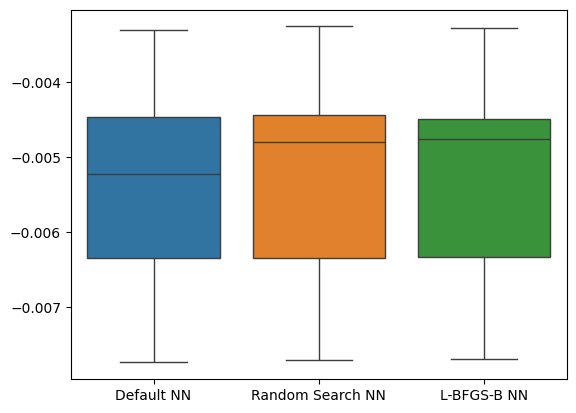

In [ ]:
sns.boxplot(cv_error)

In [ ]:
#Now that we have come this far, let's see if our ensemble approach is worth the trouble
baseline = LinearRegression()
default_nn = MLPRegressor()

#The SGD Regressor will predict the future price
sgd_regressor = SGDRegressor(tol= 0.001,
 shuffle=False,
 penalty= 'elasticnet',
 loss= 'huber',
 learning_rate='adaptive',
 fit_intercept= True,
 early_stopping= True,
 alpha= 1e-05)

#The deep neural network will predict the error in the SGDRegressor's prediction
lbfgs_customized_model = MLPRegressor(
    tol                 = result.x[0],
    solver              = tuner.best_params_['solver'],
    power_t             = result.x[1],
    max_iter            = tuner.best_params_['max_iter'],
    learning_rate       = tuner.best_params_['learning_rate'],
    learning_rate_init  = result.x[2],
    hidden_layer_sizes  = tuner.best_params_['hidden_layer_sizes'],
    alpha               = result.x[3],
    early_stopping      = tuner.best_params_['early_stopping'],
    activation          = tuner.best_params_['activation'],
)

In [ ]:
#Fit the models on the train set
baseline.fit(train_X.loc[:,['Close']],train_y)
default_nn.fit(train_X.loc[:,['Close']],train_y)
sgd_regressor.fit(train_X.loc[:,['Close']],train_y)
lbfgs_customized_model.fit(residuals_train_X.loc[:,['Open','High','Low']],residuals_train_y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='identity', alpha=9.999995026699497e-06,
             hidden_layer_sizes=(30, 200, 40),
             learning_rate_init=0.009999995026699496, max_iter=300,
             power_t=0.4999997513349748, solver='lbfgs',
             tol=9.999995026699498e-05)

In [ ]:
#Store the models in a list
models = [baseline,default_nn,sgd_regressor,lbfgs_customized_model]

In [ ]:
#Create a dataframe to store our error
ensemble_error = pd.DataFrame(index=np.arange(0,5),columns=['Baseline','Default NN','SGD','Customized NN'])

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [ ]:
#Create the time-series object
tscv = TimeSeriesSplit(n_splits=5,gap=20)

In [ ]:
#Reset the indexes so we can perform cross validation
test_y = test_y.reset_index()
residuals_test_y = residuals_test_y.reset_index()

test_X = test_X.reset_index()
residuals_test_X = residuals_test_X.reset_index()

In [ ]:
#Cross validate the models
for j in np.arange(0,4):
  model = models[j]
  for i,(train,test) in enumerate(tscv.split(test_X)):
    #The model predicting the residuals
    if(j == 3):
      model.fit(residuals_test_X.loc[train[0]:train[-1],['Open','High','Low']],residuals_test_y.loc[train[0]:train[-1],'Target'])
      #Measure the loss
      ensemble_error.iloc[i,j] = mean_squared_error(residuals_test_y.loc[test[0]:test[-1],'Target' ], model.predict(residuals_test_X.loc[test[0]:test[-1],['Open','High','Low']]))

    elif(j <= 2):
      #Fit the model
      model.fit(test_X.loc[train[0]:train[-1],['Close']],test_y.loc[train[0]:train[-1],'Target'])
      #Measure the loss
      ensemble_error.iloc[i,j] = mean_squared_error(test_y.loc[test[0]:test[-1],'Target' ],model.predict(test_X.loc[test[0]:test[-1],['Close']]))

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

In [ ]:
ensemble_error.mean().sort_values(ascending=True)

Baseline         0.004784
Customized NN    0.004891
SGD              0.005937
Default NN       35.35851
dtype: object

In [ ]:
#Prepare to export to ONNX
import onnx
import netron
from   skl2onnx import convert_sklearn
from   skl2onnx.common.data_types import FloatTensorType

In [ ]:
#Fit the SGD model on all the data we have
close_model = SGDRegressor(tol= 0.001,
 shuffle=False,
 penalty= 'elasticnet',
 loss= 'huber',
 learning_rate='adaptive',
 fit_intercept= True,
 early_stopping= True,
 alpha= 1e-05)

close_model.fit(nzd_jpy.loc[:,['Close']],nzd_jpy.loc[:,'Target'])

SGDRegressor(alpha=1e-05, early_stopping=True, learning_rate='adaptive',
             loss='huber', penalty='elasticnet', shuffle=False)

In [ ]:
#Fit the deep neural network on all the data we have
residuals_model = MLPRegressor(
 tol=0.0001,
 solver= 'lbfgs',
 shuffle=False,
 power_t= 0.5,
 max_iter= 300,
 learning_rate_init= 0.01,
 learning_rate='constant',
 hidden_layer_sizes=(30, 200, 40),
 early_stopping=False,
 alpha=1e-05,
 activation='identity')

#Fit the model on the residuals
residuals_model.fit(residuals_train_X,residuals_train_y)
residuals_model.fit(residuals_test_X,residuals_test_y)

In [ ]:
# Define the input type
close_initial_types = [("float_input",FloatTensorType([1,1]))]
residuals_initial_types = [("float_input",FloatTensorType([1,3]))]

In [ ]:
# Create the ONNX representation
close_onnx_model = convert_sklearn(close_model,initial_types=close_initial_types,target_opset=12)
residuals_onnx_model = convert_sklearn(residuals_model,initial_types=residuals_initial_types,target_opset=12)

In [ ]:
#Save the ONNX Models
onnx.save_model(close_onnx_model,'close_model.onnx')
onnx.save_model(residuals_onnx_model,'residuals_model.onnx')